In [1]:
import pandas as pd
import numpy as np
import os

# Define the directories
truth_dir = 'own/truth'
imu_dir = 'own/imu'
combined_dir = 'own/combined'

# Create the combined directory if it doesn't exist
os.makedirs(combined_dir, exist_ok=True)

# Function to process and combine GPS and IMU files
def process_files(gps_file, imu_file, output_file):
    # Load the GPS and IMU data
    gps_df = pd.read_csv(gps_file)
    mpu_df = pd.read_csv(imu_file)
    
    # Convert latitude and longitude to radians
    gps_df['lat_rad'] = np.radians(gps_df['lat'])
    gps_df['lon_rad'] = np.radians(gps_df['lon'])

    # Assume central latitude for the equirectangular approximation
    central_lat = gps_df['lat_rad'].mean()

    # Radius of Earth in meters
    R = 6371000

    # Calculate X and Y coordinates
    gps_df['x'] = R * (gps_df['lon_rad'] - gps_df['lon_rad'].mean()) * np.cos(central_lat)
    gps_df['y'] = R * (gps_df['lat_rad'] - gps_df['lat_rad'].mean())

    # Ensure all coordinates are positive
    gps_df['x'] = gps_df['x'] - gps_df['x'].min()
    gps_df['y'] = gps_df['y'] - gps_df['y'].min()

    # Combine date and time into a single datetime column
    gps_df['datetime'] = pd.to_datetime(gps_df['date'] + ' ' + gps_df['time'])

    # Drop rows with null datetime values from the GPS data
    gps_df = gps_df.dropna(subset=['datetime'])

    # Add 1 hour to the GPS datetime values
    gps_df['datetime'] = gps_df['datetime'] + pd.Timedelta(hours=1)

    # Convert the timestamp column in the MPU data to datetime format
    mpu_df['timestamp'] = pd.to_datetime(mpu_df['timestamp'])

    # Merge the GPS data into the MPU data
    combined_df = pd.merge_asof(mpu_df.sort_values('timestamp'), 
                                gps_df[['datetime', 'x', 'y']].sort_values('datetime'), 
                                left_on='timestamp', right_on='datetime', 
                                direction='nearest')

    # Interpolate missing values for x and y
    combined_df['x'] = combined_df['x'].interpolate()
    combined_df['y'] = combined_df['y'].interpolate()

    # Select and rename the required columns
    output_df = combined_df[['timestamp', 'gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'x', 'y']]
    output_df.rename(columns={'timestamp': 'date/time'}, inplace=True)

    # Save the result to the output file
    output_df.to_csv(output_file, index=False)

# Iterate over the files in the directories
for gps_file in os.listdir(truth_dir):
    if gps_file.startswith('gps-') and gps_file.endswith('.csv'):
        name = gps_file[4:-4]  # Extract the name part
        imu_file = f'imu-{name}.csv'
        
        gps_path = os.path.join(truth_dir, gps_file)
        imu_path = os.path.join(imu_dir, imu_file)
        
        if os.path.exists(imu_path):
            output_file = os.path.join(combined_dir, f'{name}.csv')
            process_files(gps_path, imu_path, output_file)
print('Complete')

/tmp/ipykernel_77794/2468306744.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df.rename(columns={'timestamp': 'date/time'}, inplace=True)
/tmp/ipykernel_77794/2468306744.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df.rename(columns={'timestamp': 'date/time'}, inplace=True)
/tmp/ipykernel_77794/2468306744.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df.rename(columns={'timestamp': 'date/time'

Complete


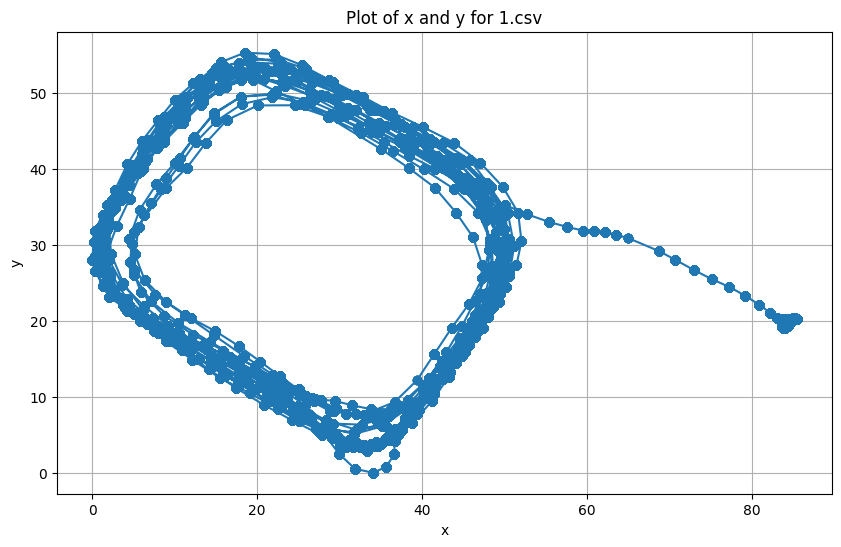

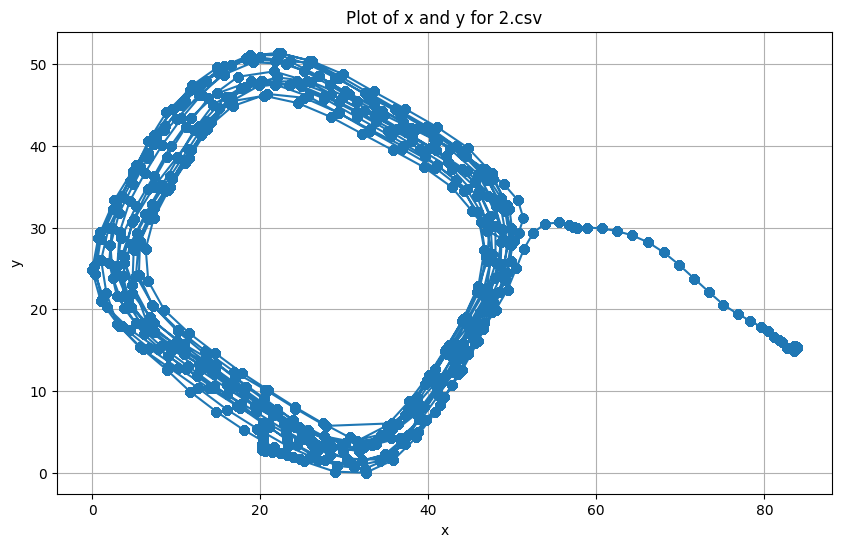

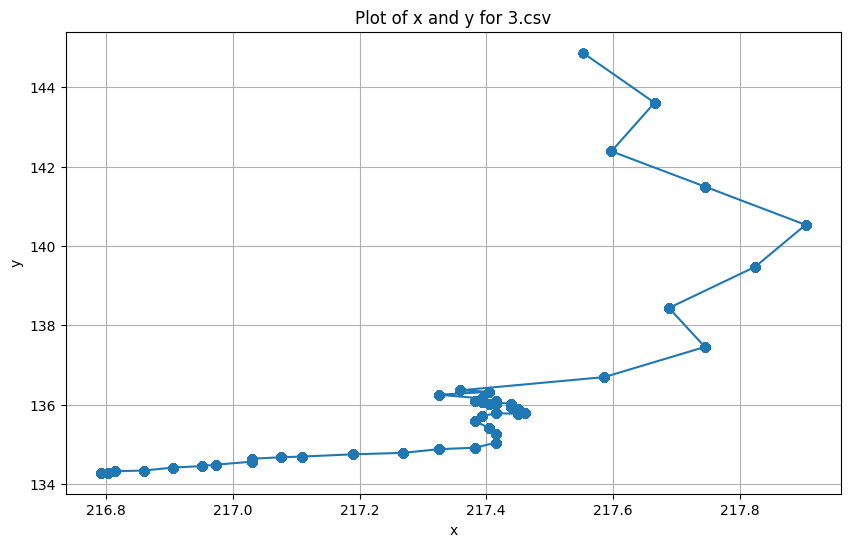

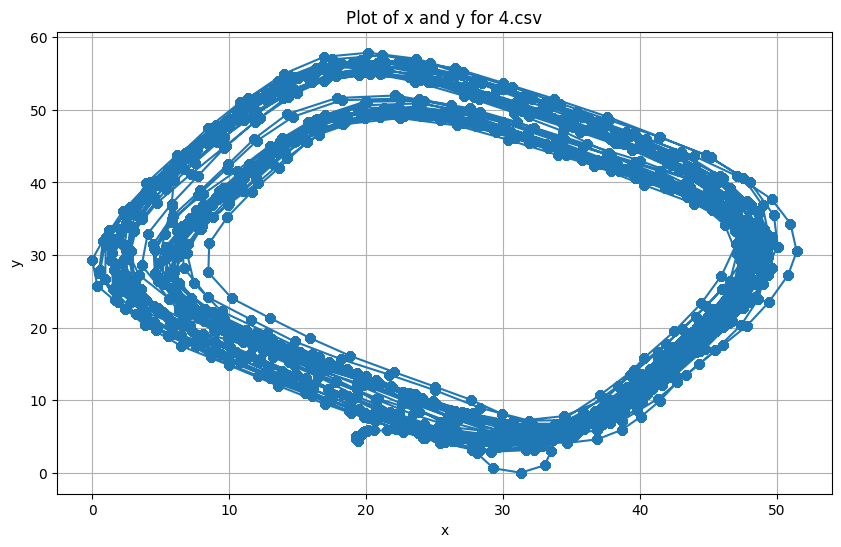

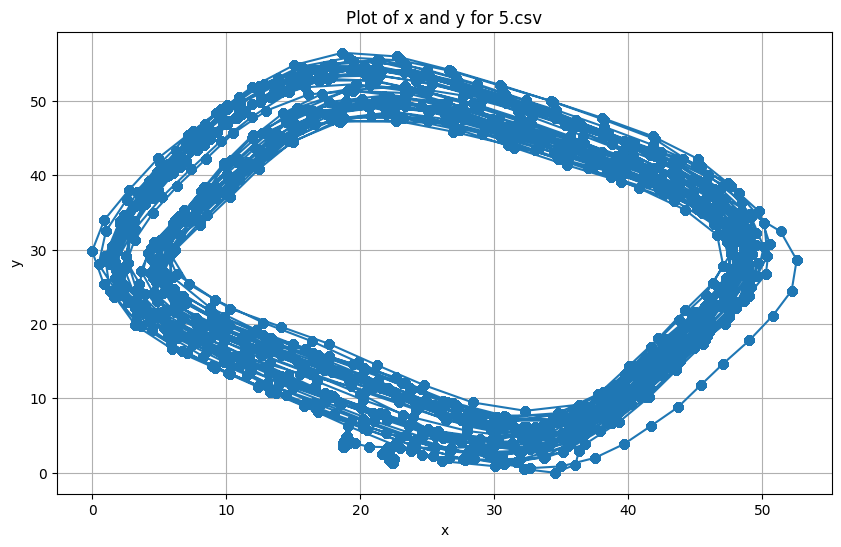

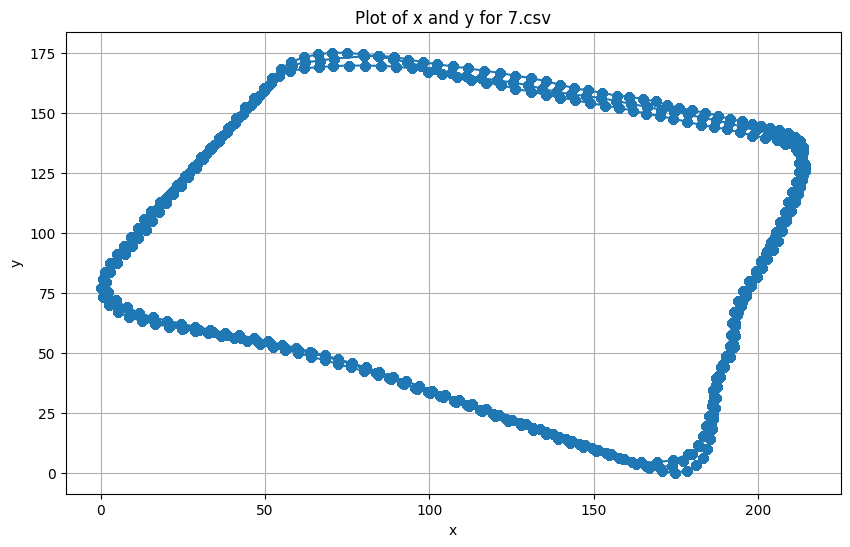

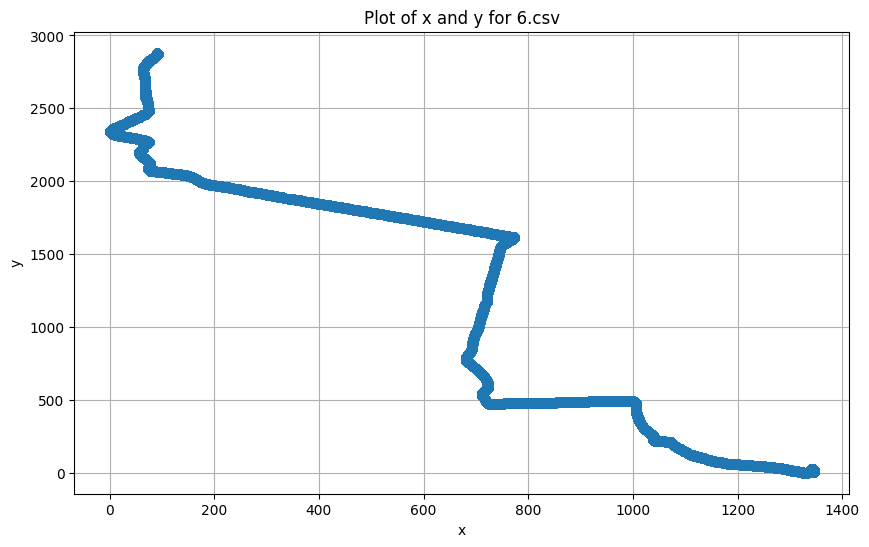

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define the directory
combined_dir = 'own/combined'

# Function to plot x and y columns
def plot_xy(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Plot the x and y columns
    plt.figure(figsize=(10, 6))
    plt.plot(df['x'], df['y'], marker='o', linestyle='-')
    plt.title(f'Plot of x and y for {os.path.basename(file_path)}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

# Iterate over the files in the combined directory
for combined_file in os.listdir(combined_dir):
    if combined_file.endswith('.csv'):
        file_path = os.path.join(combined_dir, combined_file)
        plot_xy(file_path)
